# Az adatállományról
Kontextus

Ez az adatkészlet 21000 képet tartalmaz.
Ebből az első 16 legtöb képet tartalmazó osztályt használtam a tanításra, ezekből is egyenként 400 képet vettem ki.
Ezt az adathalmazt arra használhatja, hogy felismerje a közlekedési táblákat a fotóról.

Tartalom

A képek 16 osztályba vannak osztva: no_stopping, watch_out_for_cars, speed_limit_60kmh, speed_limit_40kmh,speed_limit_30kmh, speed_limit_50kmh, bicycles_crossing, speed_limit_80kmh, zebra_crossing, no_horn, keep_right, dont_go_left, speed_limit_70kmh, no_entry, no_car.
Minden osztályhoz körülbelül 400 fotót rendelünk hozzá. A fényképek nem nagy felbontásúak, körülbelül 100x100 pixelesek.

# Traffic Sign Recognition CNN Keras

TARTALOM :
1.   Különböző modulok importálása
2.   Az adatok előkészítése
3.   Modellezés
4.   Túltantás
5.   A modell teljesítményének értékelése
6.   Előrejelzések vizualizálása a validációs készleten


## 1 ) Különböző modulok importálása.

In [ ]:
!nvidia-smi

Sun May  5 18:11:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |  14083MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [588]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [589]:
pip install visualkeras

In [590]:
# Figyelmen kívül hagyja a figyelmeztetéseket
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# adatvizualizáció és -manipuláció
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import style
import seaborn as sns
import visualkeras
from keras.layers import LeakyReLU

#configure
# a matplotlib-ot inline-ra állítja, és megjeleníti a grafikonokat a megfelelő cella alatt.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#modell kiválasztása
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder

#előfeldolgozás.
from keras.preprocessing.image import ImageDataGenerator

#dl könyvtárak
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# kifejezetten a CNN részére
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D

import tensorflow as tf
import random as rn

# kifejezetten a zippelt képek manipulálására és a képek pixelértékeit tartalmazó numpy tömbök kinyerésére.
import cv2
import os
from tqdm import tqdm

## 2 ) Az adatok előkészítése

## 2.1) A Képekből a gyakorló és a validációs készlet kinyerésére szolgáló függvények elkészítése

In [ ]:
X=[]
Z=[]
IMG_SIZE=128
FOLDER_NAME_EXCEPTIONS = ['unknown']

# TODO read the info.csv file and get the first column as labels
info_csv = pd.read_csv("/content/drive/My Drive/TrafficSignCNN/final_dataset/info.csv")
# CSV structure
# Folder Name,	Number of Images,	Keyword1,	Keyword2,	Keyword3,	Keyword4,	Keyword5,	Keyword6,	Keyword7
# no_stopping,	1077,	no,	stopping,
# ...

# get the first 16 folder names without the exceptions
folder_names = info_csv["Folder Name"][:16]
folder_names = folder_names[~folder_names.isin(FOLDER_NAME_EXCEPTIONS)]
display(folder_names)

0            no_stopping
1     watch_out_for_cars
2      speed_limit_60kmh
3      speed_limit_40kmh
5      speed_limit_30kmh
6      speed_limit_50kmh
7      bicycles_crossing
8      speed_limit_80kmh
9         zebra_crossing
10               no_horn
11            keep_right
12          dont_go_left
13     speed_limit_70kmh
14              no_entry
15                no_car
Name: Folder Name, dtype: object

In [591]:
def assign_label(img,img_type):
    return img_type

In [592]:
def make_train_data(img_type, DIR, max_images_per_class=400):
    class_count = 0

    for img in os.listdir(DIR):
        if class_count >= max_images_per_class:
            break

        label = assign_label(img, img_type)

        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        im_rgb = cv2.resize(im_rgb, (IMG_SIZE, IMG_SIZE))

        X.append(np.array(im_rgb))
        Z.append(str(label))

        class_count += 1

    print(f"Processed {class_count} images for class: {img_type}")


In [ ]:
# for each folder in folder_names lets assign the foldername as a label
for folder_name in folder_names:
    print(folder_name)
    make_train_data(folder_name,f"/content/drive/My Drive/TrafficSignCNN/final_dataset/{folder_name}")
    print(len(X))

no_stopping
Processed 400 images for class: no_stopping
400
watch_out_for_cars
Processed 400 images for class: watch_out_for_cars
800
speed_limit_60kmh
Processed 400 images for class: speed_limit_60kmh
1200
speed_limit_40kmh
Processed 400 images for class: speed_limit_40kmh
1600
speed_limit_30kmh
Processed 400 images for class: speed_limit_30kmh
2000
speed_limit_50kmh
Processed 400 images for class: speed_limit_50kmh
2400
bicycles_crossing
Processed 400 images for class: bicycles_crossing
2800
speed_limit_80kmh
Processed 400 images for class: speed_limit_80kmh
3200
zebra_crossing
Processed 400 images for class: zebra_crossing
3600
no_horn
Processed 400 images for class: no_horn
4000
keep_right
Processed 400 images for class: keep_right
4400
dont_go_left
Processed 400 images for class: dont_go_left
4800
speed_limit_70kmh
Processed 400 images for class: speed_limit_70kmh
5200
no_entry
Processed 400 images for class: no_entry
5600
no_car
Processed 400 images for class: no_car
6000


## 2.2 ) Visualizing the Classes

In [ ]:
import random

# Initialize a dictionary to store the count of images in each class
class_count = {}
data_dir = "/content/drive/My Drive/TrafficSignCNN/final_dataset"
# Iterate over the directories in the data directory
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        # Count the number of files in the directory (assuming each file is an image)
        num_images = len(os.listdir(class_dir))
        # Store the count for this class
        class_count[class_name] = num_images

# Sort classes by image count in ascending order
sorted_classes = sorted(class_count.items(), key=lambda x: x[1])

# Extract class names and image counts
class_names = [item[0] for item in sorted_classes]
image_counts = [item[1] for item in sorted_classes]

# Define 16 custom colors for each bar
colors = ['#' + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(class_names))]

# Create a bar plot using Plotly
fig = go.Figure(data=[go.Bar(
    x=image_counts,
    y=class_names,
    orientation='h',
    marker_color=colors,
)])

# Customize layout
fig.update_layout(
    title='Number of Images in Each Class',
    xaxis_title='Number of Images',
    yaxis_title='Class',
    yaxis=dict(autorange="reversed"),  # Invert y-axis to have the class with the highest count at the top
)

# Show plot
fig.show()

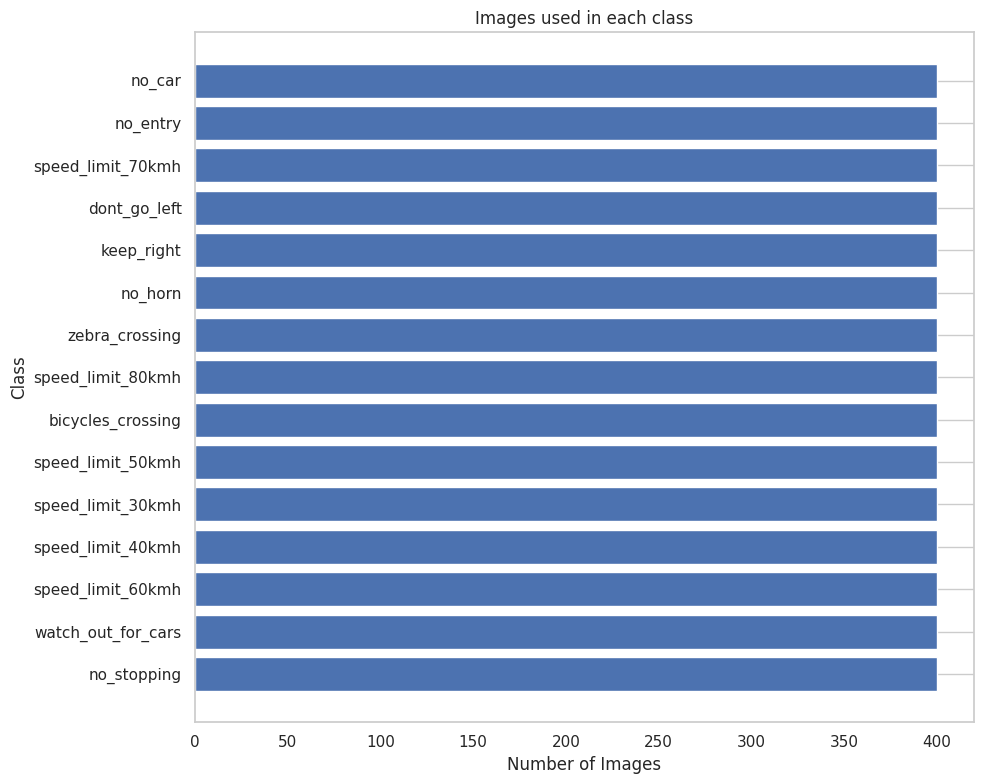

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Images used in each class')

# Create a dictionary to store the count of images for each class
class_counts = {folder_name: 400 for folder_name in folder_names}

# Plot the histogram
plt.barh(range(len(folder_names)), list(class_counts.values()), height=0.8)

# Set the tick labels to the folder names
plt.yticks(range(len(folder_names)), folder_names)

plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

## 2.2 ) Néhány véletlenszerű kép vizualizációja

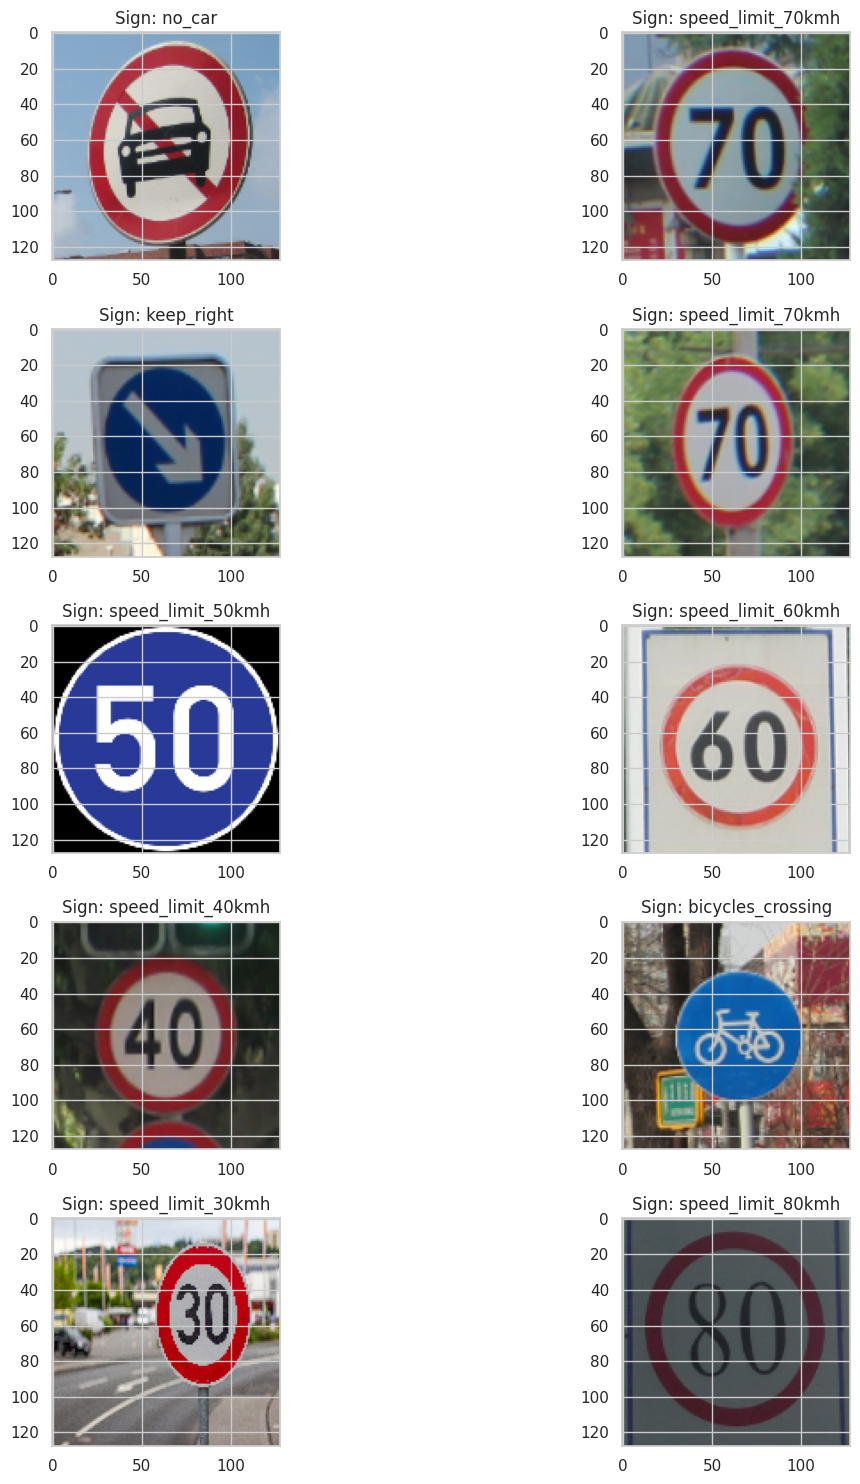

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Sign: '+Z[l])

plt.tight_layout()

## 2.3 ) Címkekódolás az Y tömbben majd One Hot Encoding

In [ ]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,16)
X=np.array(X)
X=X/255

## 2.4 ) Felosztás képzési és validálási halmazokra

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

## 2.5 ) A véletlen magok beállítása

In [ ]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## 3 ) Modellezés

## 3.1 ) A ConvNet modell felépítése

In [ ]:
# # modelling starts using a CNN.
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same'))
model.add(LeakyReLU(alpha=0.1))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same'))
model.add(LeakyReLU(alpha=0.1))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.1))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.1))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.1))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.1))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(16, activation = "softmax"))

## 3.2 ) LR lágyító használata

In [ ]:
batch_size=200
epochs=45

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Adatbővítés a túlillesztés megakadályozására

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # a bemeneti átlagot 0-ra állítja az adathalmazon
        samplewise_center=False,  # minden minta átlagát 0-ra állítsuk
        featurewise_std_normalization=False,  # a bemenetek osztása az adatállomány std értékével
        samplewise_std_normalization=False,  # osszuk el az egyes bemeneteket az std
        zca_whitening=False,  # alkalmazni ZCA fehérítés
        rotation_range=20,  # véletlenszerűen forgatja a képeket a (0 és 20 fok közötti) tartományban.
        zoom_range=0.2,  # Kép véletlenszerű nagyítása (0.8 és 1.2 közötti tartomány)
        width_shift_range=0.1,  # a képek véletlenszerű vízszintes eltolása (a teljes szélesség 10%-a)
        height_shift_range=0.1,  # a képek véletlenszerű függőleges eltolása (a teljes magasság 10%-a)
        shear_range=0.2,  # véletlenszerű nyírási transzformáció (0 és 0.2 közötti tartomány)
        horizontal_flip=True,  # véletlenszerűen flip képek vízszintesen
        vertical_flip=True,  # ne alkalmazzunk függőleges flip-et
        )  # kitöltési mód a transzformált képeken kívüli pontokhoz

datagen.fit(x_train)

## 3.4 ) A Keras modell fordítása és összefoglaló

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_459 (Conv2D)         (None, 128, 128, 32)      2432      
                                                                 
 conv2d_460 (Conv2D)         (None, 128, 128, 32)      25632     
                                                                 
 leaky_re_lu_208 (LeakyReLU  (None, 128, 128, 32)      0         
 )                                                               
                                                                 
 average_pooling2d_123 (Ave  (None, 64, 64, 32)        0         
 ragePooling2D)                                                  
                                                                 
 conv2d_461 (Conv2D)         (None, 64, 64, 32)        25632     
                                                                 
 conv2d_462 (Conv2D)         (None, 64, 64, 32)      

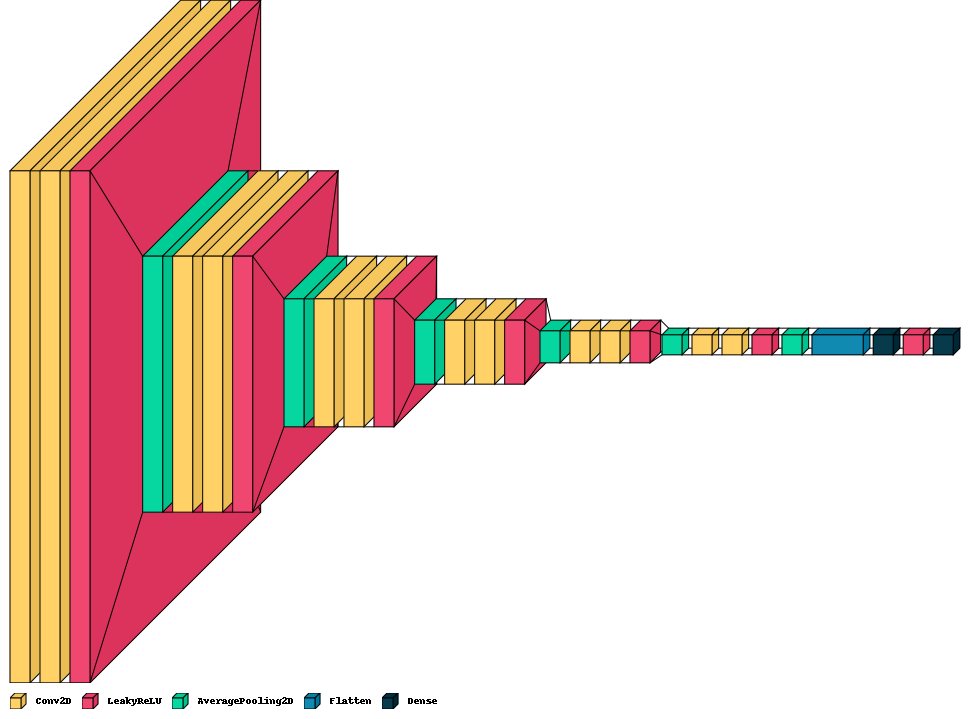

In [ ]:
visualkeras.layered_view(model, legend=True)

## 3.5 ) Illesztés a gyakorlóhalmazon és előrejelzések készítése a validációs halmazon

In [ ]:
History = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# History = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/45
22/22 [==============================] - 20s 726ms/step - loss: 2.8912 - accuracy: 0.0760 - val_loss: 2.7400 - val_accuracy: 0.0633
Epoch 2/45
22/22 [==============================] - 15s 688ms/step - loss: 2.7084 - accuracy: 0.0728 - val_loss: 2.6241 - val_accuracy: 0.1673
Epoch 3/45
22/22 [==============================] - 15s 683ms/step - loss: 2.6632 - accuracy: 0.1098 - val_loss: 2.6402 - val_accuracy: 0.1133
Epoch 4/45
22/22 [==============================] - 15s 687ms/step - loss: 2.6030 - accuracy: 0.1340 - val_loss: 2.4518 - val_accuracy: 0.1927
Epoch 5/45
22/22 [==============================] - 15s 685ms/step - loss: 2.4845 - accuracy: 0.1933 - val_loss: 2.5100 - val_accuracy: 0.1327
Epoch 6/45
22/22 [==============================] - 15s 667ms/step - loss: 2.6261 - accuracy: 0.1160 - val_loss: 2.4633 - val_accuracy: 0.1400
Epoch 7/45
22/22 [==============================] - 15s 668ms/step - loss: 2.3639 - accuracy: 0.1886 - val_loss: 2.2916 - val_accuracy: 0.2500

## 4 ) A modell teljesítményének értékelése

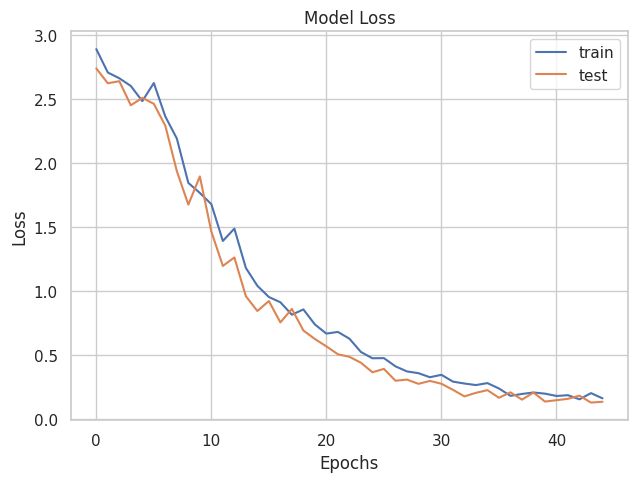

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
print(History.history)

{'loss': [2.89121675491333, 2.7083845138549805, 2.6631598472595215, 2.6029932498931885, 2.484527111053467, 2.6260857582092285, 2.363945722579956, 2.19169282913208, 1.8445320129394531, 1.766175389289856, 1.6781526803970337, 1.390363097190857, 1.4868762493133545, 1.179476022720337, 1.0396171808242798, 0.9519306421279907, 0.9107643961906433, 0.8132241368293762, 0.8547473549842834, 0.7371169924736023, 0.6654782295227051, 0.6787633895874023, 0.6259145736694336, 0.5220628976821899, 0.4725993275642395, 0.4738124907016754, 0.40967753529548645, 0.3697965443134308, 0.35600295662879944, 0.32431599497795105, 0.34315580129623413, 0.2900184094905853, 0.2750351130962372, 0.26307377219200134, 0.2783512473106384, 0.23628050088882446, 0.17864005267620087, 0.1935640275478363, 0.2047463208436966, 0.19594340026378632, 0.1777667999267578, 0.18365474045276642, 0.15156246721744537, 0.20000074803829193, 0.1592540144920349], 'accuracy': [0.07604651153087616, 0.07279069721698761, 0.10976744443178177, 0.133953481

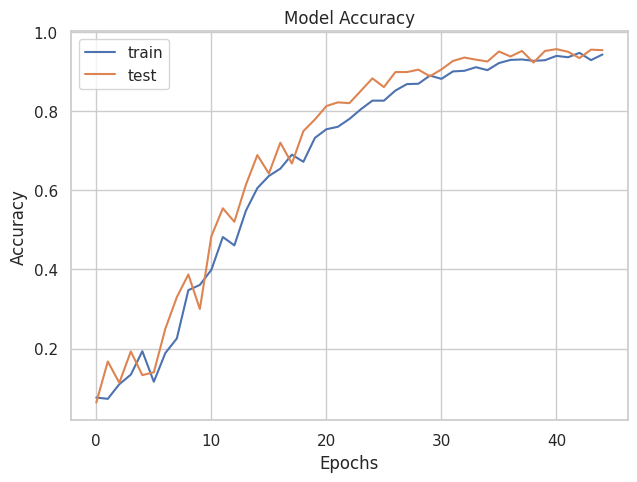

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## 5 ) Előrejelzések vizualizálása a validációs készleten

In [ ]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

47/47 [==============================] - 1s 15ms/step


In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### HELYESEN OSZTÁLYOZOTT KÉPEK

In [ ]:
print(le.inverse_transform([pred_digits[prop_class[0]]]))

['no_horn']


In [ ]:
print([y_test[prop_class[0]]])

[array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)]


In [ ]:
print(le.inverse_transform(np.argmax([y_test[prop_class[0]]], axis=1)))

['no_horn']


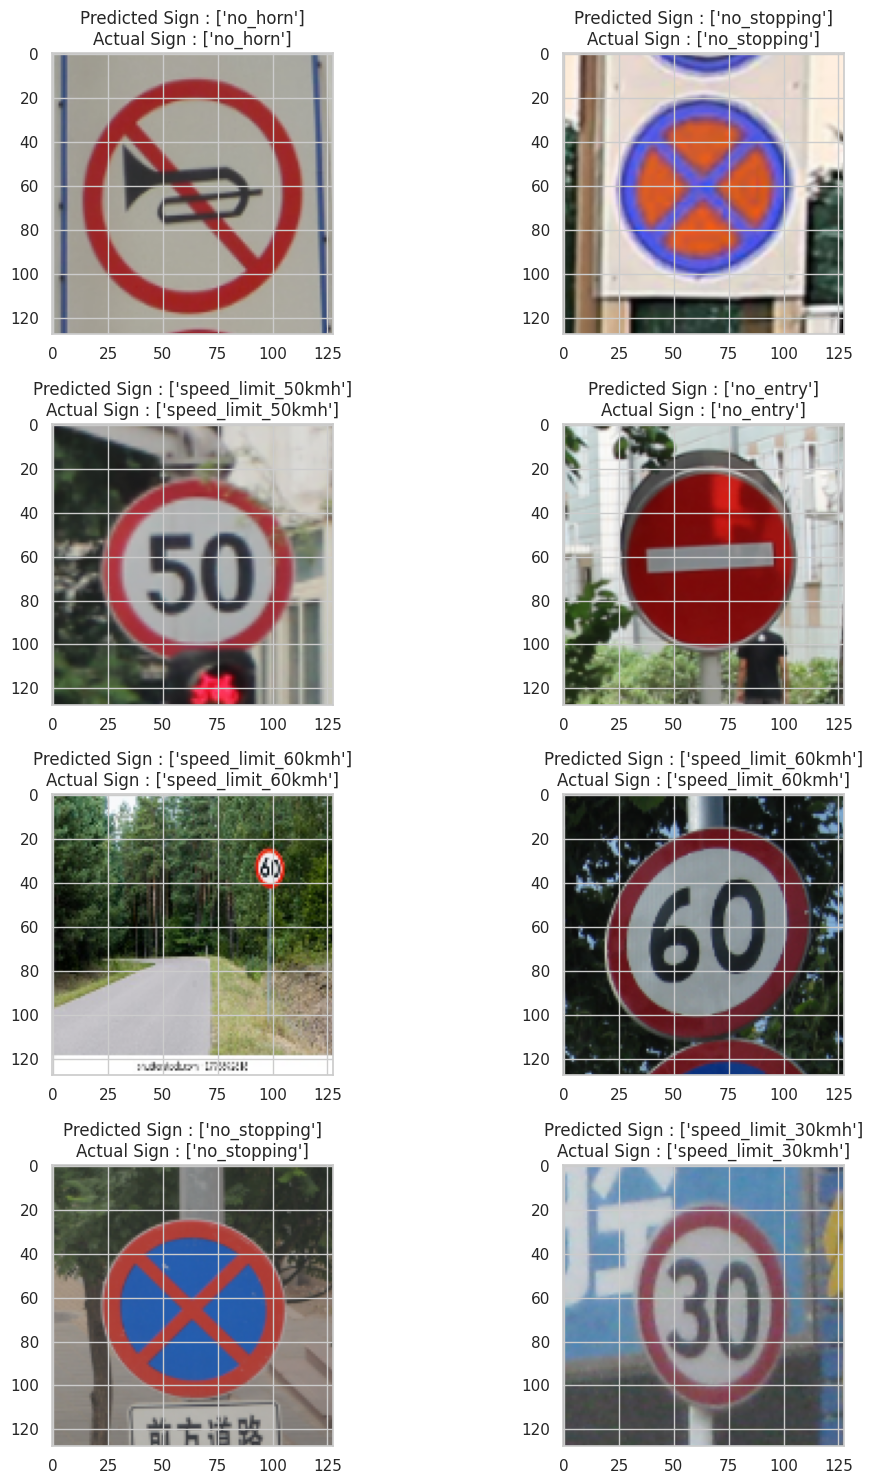

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Sign : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Sign : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]], axis=1))))
        plt.tight_layout()
        count+=1

#### TÉVESEN BESOROLT KÉPEK

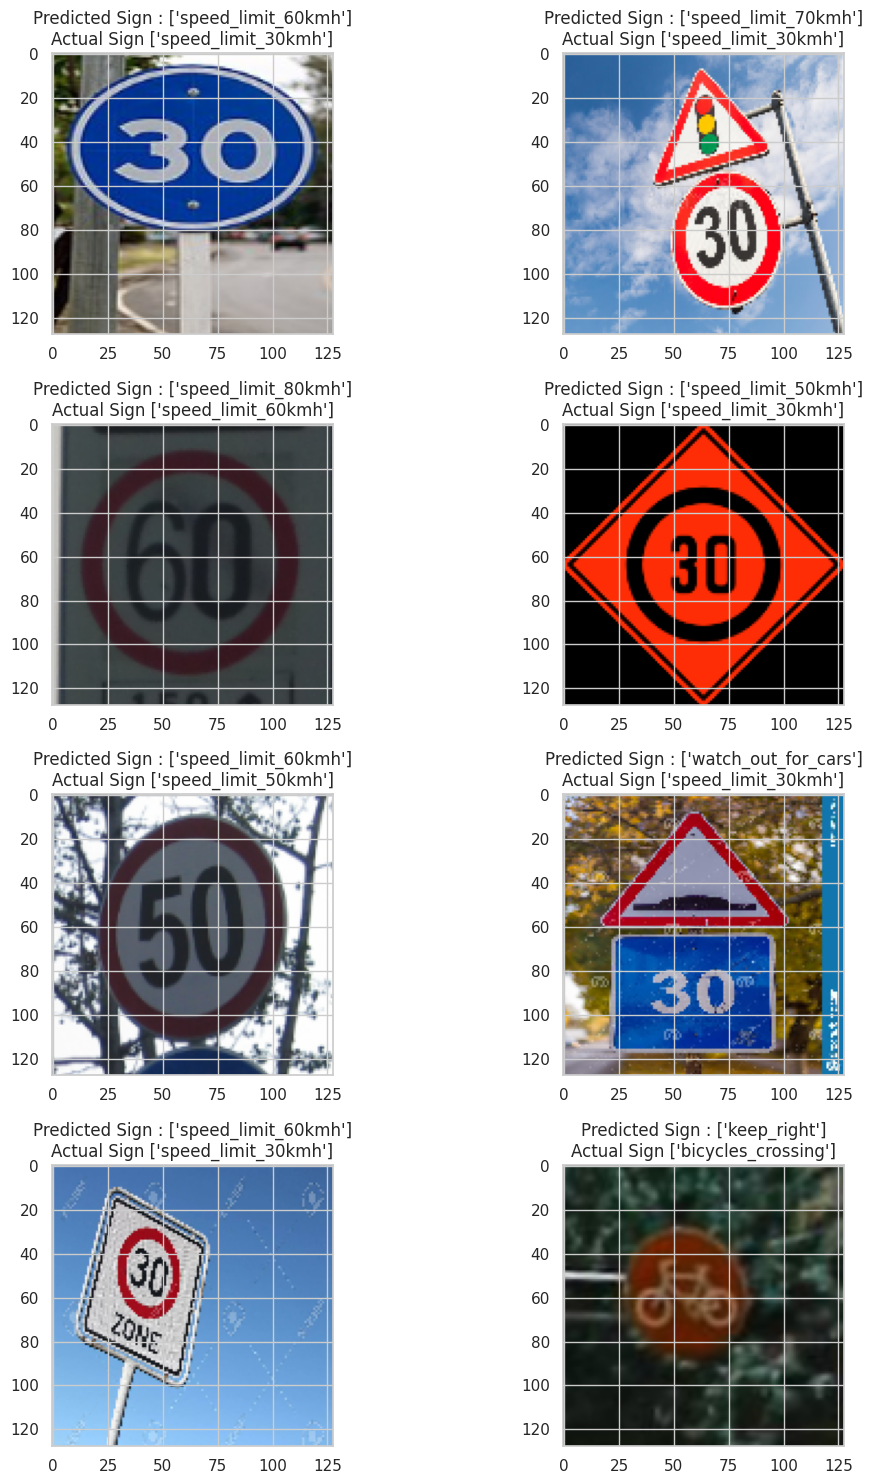

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Sign : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Sign "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]], axis=1))))
        plt.tight_layout()
        count+=1

# Túltanítás

In [593]:
X=[]
Z=[]
IMG_SIZE=128
FOLDER_NAME_EXCEPTIONS = ['unknown']

# TODO read the info.csv file and get the first column as labels
info_csv = pd.read_csv("/content/drive/My Drive/TrafficSignCNN/final_dataset/info.csv")
# CSV structure
# Folder Name,	Number of Images,	Keyword1,	Keyword2,	Keyword3,	Keyword4,	Keyword5,	Keyword6,	Keyword7
# no_stopping,	1077,	no,	stopping,
# ...

# get the first 16 folder names without the exceptions
folder_names = info_csv["Folder Name"][:16]
folder_names = folder_names[~folder_names.isin(FOLDER_NAME_EXCEPTIONS)]
display(folder_names)

0            no_stopping
1     watch_out_for_cars
2      speed_limit_60kmh
3      speed_limit_40kmh
5      speed_limit_30kmh
6      speed_limit_50kmh
7      bicycles_crossing
8      speed_limit_80kmh
9         zebra_crossing
10               no_horn
11            keep_right
12          dont_go_left
13     speed_limit_70kmh
14              no_entry
15                no_car
Name: Folder Name, dtype: object

In [594]:
# for each folder in folder_names lets assign the foldername as a label
for folder_name in folder_names:
    print(folder_name)
    make_train_data(folder_name,f"/content/drive/My Drive/TrafficSignCNN/final_dataset/{folder_name}",100)
    print(len(X))

no_stopping
Processed 100 images for class: no_stopping
100
watch_out_for_cars
Processed 100 images for class: watch_out_for_cars
200
speed_limit_60kmh
Processed 100 images for class: speed_limit_60kmh
300
speed_limit_40kmh
Processed 100 images for class: speed_limit_40kmh
400
speed_limit_30kmh
Processed 100 images for class: speed_limit_30kmh
500
speed_limit_50kmh
Processed 100 images for class: speed_limit_50kmh
600
bicycles_crossing
Processed 100 images for class: bicycles_crossing
700
speed_limit_80kmh
Processed 100 images for class: speed_limit_80kmh
800
zebra_crossing
Processed 100 images for class: zebra_crossing
900
no_horn
Processed 100 images for class: no_horn
1000
keep_right
Processed 100 images for class: keep_right
1100
dont_go_left
Processed 100 images for class: dont_go_left
1200
speed_limit_70kmh
Processed 100 images for class: speed_limit_70kmh
1300
no_entry
Processed 100 images for class: no_entry
1400
no_car
Processed 100 images for class: no_car
1500


In [612]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,16)
X=np.array(X)
X=X/255

In [596]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=42)

In [597]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [704]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[128, 128, 3]),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  # Slightly reduced to check for stability
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [705]:
cnn.summary()

Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_638 (Conv2D)         (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_167 (MaxPool  (None, 63, 63, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_639 (Conv2D)         (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_168 (MaxPool  (None, 30, 30, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_640 (Conv2D)         (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_169 (MaxPool  (None, 14, 14, 128)    

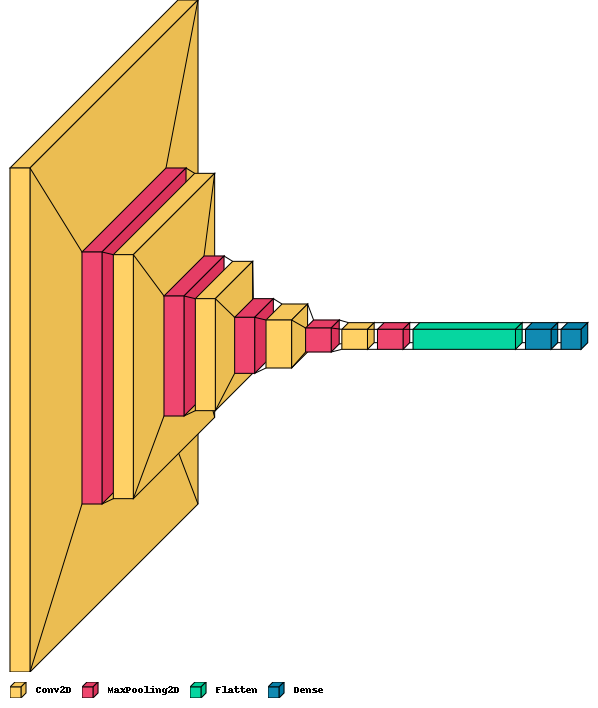

In [706]:
visualkeras.layered_view(cnn, legend=True)

In [707]:
history = cnn.fit(x_train,y_train, validation_data = (x_test,y_test), epochs=100, verbose=1, batch_size=32)

Epoch 1/100
43/43 [==============================] - 3s 26ms/step - loss: 2.5488 - accuracy: 0.1141 - val_loss: 2.0085 - val_accuracy: 0.2933
Epoch 2/100
43/43 [==============================] - 1s 18ms/step - loss: 1.7666 - accuracy: 0.3726 - val_loss: 1.6709 - val_accuracy: 0.3933
Epoch 3/100
43/43 [==============================] - 1s 19ms/step - loss: 1.2877 - accuracy: 0.5415 - val_loss: 1.0659 - val_accuracy: 0.6333
Epoch 4/100
43/43 [==============================] - 1s 19ms/step - loss: 0.8819 - accuracy: 0.6704 - val_loss: 0.8209 - val_accuracy: 0.6800
Epoch 5/100
43/43 [==============================] - 1s 19ms/step - loss: 0.6583 - accuracy: 0.7593 - val_loss: 0.8041 - val_accuracy: 0.6933
Epoch 6/100
43/43 [==============================] - 1s 19ms/step - loss: 0.4461 - accuracy: 0.8459 - val_loss: 0.3948 - val_accuracy: 0.8800
Epoch 7/100
43/43 [==============================] - 1s 19ms/step - loss: 0.2277 - accuracy: 0.9230 - val_loss: 0.2945 - val_accuracy: 0.9267
Epoch 

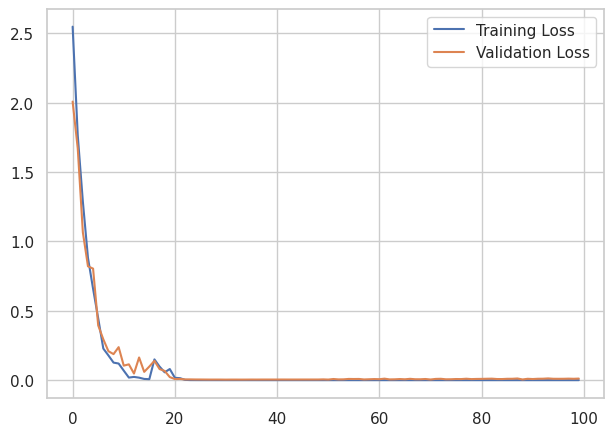

<Figure size 640x480 with 0 Axes>

In [708]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

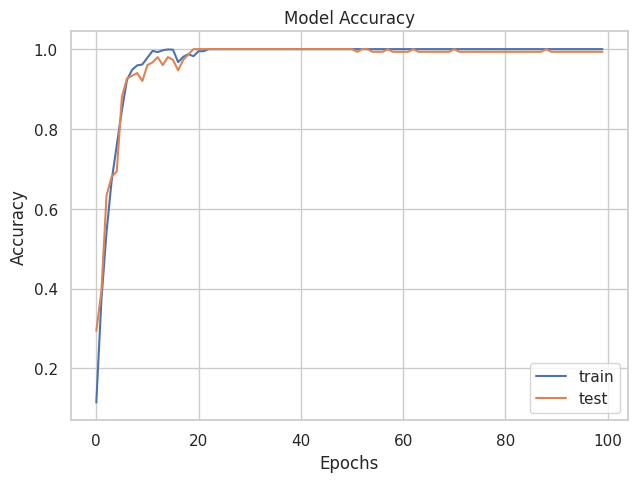

In [709]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
pred = cnn.predict(x_test)
pred=np.argmax(pred,axis=1)
y_test_argmax = np.argmax(y_test,axis=1)

5/5 [==============================] - 0s 5ms/step


In [ ]:
clf_report = pd.DataFrame(classification_report(y_test_argmax, pred, output_dict=True))
print("Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test_argmax, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_argmax, pred)}\n")

Result:
Accuracy Score: 96.67%
_______________________________________________
CLASSIFICATION REPORT:
             0     1     2    3    4    5     6          7          8  \
precision  1.0   1.0   1.0  1.0  1.0  1.0   1.0   1.000000   0.818182   
recall     1.0   1.0   1.0  1.0  1.0  1.0   1.0   0.950000   0.900000   
f1-score   1.0   1.0   1.0  1.0  1.0  1.0   1.0   0.974359   0.857143   
support    8.0  11.0  11.0  9.0  8.0  8.0  12.0  20.000000  10.000000   

                  9         10    11    12   13   14  accuracy   macro avg  \
precision  0.750000   0.875000   1.0   1.0  1.0  1.0  0.966667    0.962879   
recall     1.000000   0.700000   1.0   1.0  1.0  1.0  0.966667    0.970000   
f1-score   0.857143   0.777778   1.0   1.0  1.0  1.0  0.966667    0.964428   
support    6.000000  10.000000  12.0  11.0  6.0  8.0  0.966667  150.000000   

           weighted avg  
precision      0.969545  
recall         0.966667  
f1-score       0.966528  
support      150.000000  
___________

In [ ]:
def perf_measure(y_test, y_pred):
    CM = confusion_matrix(y_test, y_pred)

    for i in range(5):
        #5 osztaly a ciklus alapjan
        print(str(le.inverse_transform([i]))," osztaly: " ,i+1)
        TP = CM[i][i]
        FP = CM[i,:].sum() - TP
        FN = CM[:,i].sum() - TP
        TN = CM[:,:].sum() - TP - FP - FN

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)

        # Specificity or true negative rate
        TNR = TN/(TN+FP)

        # PPV positive predictive value
        PPV = TP/(TP+FP)

        # NPV negative predictive value
        NPV = TN/(TN+FN)

        #Accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        #Dice score
        DS = (2*TP)/((2*TP)+FP+FN)

        print("True positive :", TP)
        print("True negative :", TN)
        print("False positive :", FP)
        print("False negative :", FN, '\n')

        print("True positive rate :", TPR)
        print("True negative rate :", TNR)
        print("Positive predictive value :", PPV)
        print("Negative predictive value :", NPV)
        print("Accuracy :", ACC)
        print("Dice score :", DS, '\n')

In [ ]:
perf_measure(y_test_argmax, pred)

['bicycles_crossing']  osztaly:  1
True positive : 8
True negative : 142
False positive : 0
False negative : 0 

True positive rate : 1.0
True negative rate : 1.0
Positive predictive value : 1.0
Negative predictive value : 1.0
Accuracy : 1.0
Dice score : 1.0 

['dont_go_left']  osztaly:  2
True positive : 11
True negative : 139
False positive : 0
False negative : 0 

True positive rate : 1.0
True negative rate : 1.0
Positive predictive value : 1.0
Negative predictive value : 1.0
Accuracy : 1.0
Dice score : 1.0 

['keep_right']  osztaly:  3
True positive : 11
True negative : 139
False positive : 0
False negative : 0 

True positive rate : 1.0
True negative rate : 1.0
Positive predictive value : 1.0
Negative predictive value : 1.0
Accuracy : 1.0
Dice score : 1.0 

['no_car']  osztaly:  4
True positive : 9
True negative : 141
False positive : 0
False negative : 0 

True positive rate : 1.0
True negative rate : 1.0
Positive predictive value : 1.0
Negative predictive value : 1.0
Accuracy : 